In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numba import njit

## Naive Radical Polymerization Model

This is a naive implementation of a radical homopolymerization model. The chain length distribution is computed by numerically solving the discrete population balances. While admittedly employing an inefficient brute-force approach (be prepared to wait 20+ seconds), this method serves a pedagogical purpose by offering transparency in its workings.

## Input parameters

In [2]:
# Parameters
kp = 2e3 # L/(mol.s)
kt = 1e8  # L/(mol.s)
kd = 1e-4 # 1/s
f = 0.5 

# Initial concentrations
M0 = 1. # mol/L
I0 = 1e-2 # mol/L

# Simulation time
tend = 3600 # s

# Initialization distributions
nmax = 1000
x = np.arange(0, nmax+1)
R0 = np.zeros_like(x)
D0 = np.zeros_like(x)

# State vector sections
state_vector_sections = (1, 2, 2+nmax+1)

In [3]:
# Initial kinetic chain length, to get an idea of DPn
# nmax must be well above this value
kp/(2*np.sqrt(f*kd*kt)) * M0/np.sqrt(I0)

141.42135623730948

## Population balance equations

In [4]:
@njit()
def propagation(P: np.ndarray, M: float, k: float):
    """P(n) + M -> P(n+1)
    
    d[Pn]/dt = k*M*([Pn-1] - [Pn])
    """
    Pdot= np.zeros_like(P)
    Pdot[1:] = P[:-1]
    Pdot -= P
    Pdot *= k*M
    return Pdot

@njit()
def combination(P: np.ndarray, k: float):
    """P(n) + P(m) -> D(n+m)
    
    d[Pn]/dt = -2*k*[Pn]*[P]
    d[Dn]/dt = k * sum i=1:n-1 [Pn-i]*[P_i]
    """
    # d[Pn]/dt
    Pdot = -2*kt*P*P.sum()
    # d[Dn]/dt
    Ddot = np.zeros_like(P)
    for n in range(2, P.size):
        accum = 0.
        for i in range(1, n):
            accum += P[i]*P[n-i]
        Ddot[n] = accum
    Ddot *= k
    return Pdot, Ddot

@njit()
def ydot(t: float, y: np.ndarray):
    """dy/dt"""
    # Unpack the state vector
    I, M, R, D = np.split(y, state_vector_sections)
    # d[I]/dt
    Idot = -kd*I
    # d[M]/dt
    ri = 2*f*kd*I[0]
    Mdot = -kp*M*R.sum() - ri
    # d[Rn]/dt, d[Dn]/dt
    Rdot = propagation(R, M[0], kp)
    Rdot_, Ddot = combination(R, kt)
    Rdot += Rdot_
    Rdot[1] += ri
    # Assemble derivative state vector
    return np.concatenate((Idot, Mdot, Rdot, Ddot))

## ODE Solution

In [5]:
teval = np.linspace(0, tend, 100)
y0 = np.concatenate(([I0], [M0], R0, D0))
atol = np.concatenate(([1e-6],
                       [1e-6],
                       1e-11*np.ones_like(R0),
                       1e-7*np.ones_like(D0)))

solution = solve_ivp(ydot,
                     t_span=(0, tend),
                     y0=y0,
                     t_eval = teval,
                     method='LSODA', # implicit solver is a MUST 
                     rtol = 1e-3,
                     atol = atol
                    )

# Unpack results
t = solution.t
y = np.split(solution.y, state_vector_sections)

## Plots

### Scalars

Text(0.5, 0, 'time [s]')

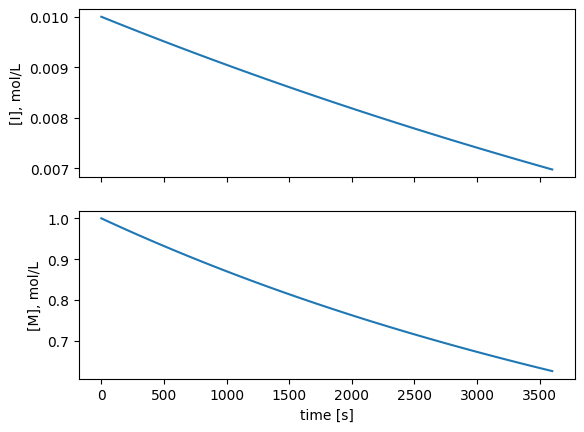

In [6]:
fig1, ax = plt.subplots(2, 1, sharex=True)
# [I] and [M]
for i in range(0, 2):
    ax[i].plot(t, y[i][0,:])
ax[0].set_ylabel("[I], mol/L")
ax[1].set_ylabel("[M], mol/L")
ax[-1].set_xlabel("time [s]")

### Moments

In [7]:
def moment(P: np.ndarray, k: int):
    "k-th moment of P"
    return np.dot(x**k, P)

Mass balance error: 5.1e-03


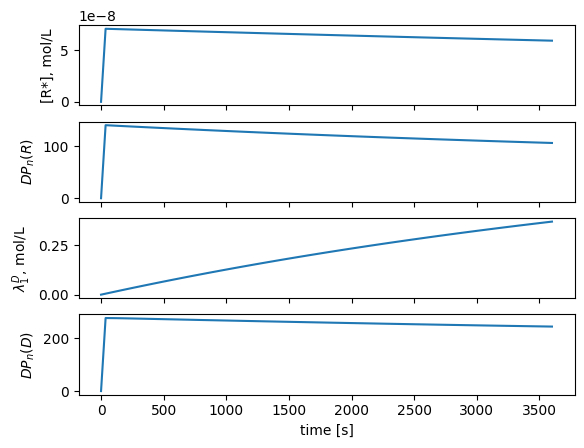

In [8]:
fig2, ax = plt.subplots(4, 1, sharex=True)
eps = np.finfo(float).eps
# 0-th moment of R*
m0_R = moment(y[2], 0)
ax[0].plot(t, m0_R)
ax[0].set_ylabel("[R*], mol/L")
# DPn R*
m1_R = moment(y[2], 1)
ax[1].plot(t, m1_R/(m0_R + eps))
ax[1].set_ylabel(r"$DP_n(R)$")
# 1st-moment of D*
m1_D = moment(y[3], 1)
ax[2].plot(t, m1_D)
ax[2].set_ylabel(r"$\lambda_1^D$" ", mol/L")
# DPn
m0_D = moment(y[3], 0)
ax[3].plot(t, m1_D/(m0_D + eps))
ax[3].set_ylabel(r"$DP_n(D)$")
ax[-1].set_xlabel("time [s]")

mass_balance_error = np.max(np.abs((m1_D + y[1][0,:])/M0 - 1.0))
print(f"Mass balance error: {mass_balance_error:.1e}")

### Chain-length distribution

Text(0.5, 0, 'Chain length')

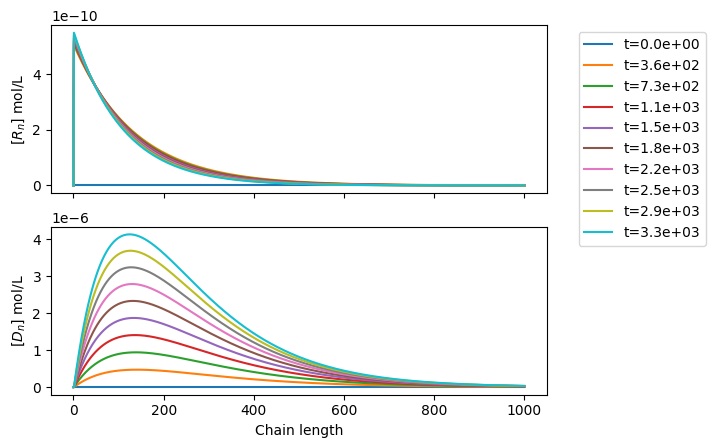

In [9]:
fig3, ax = plt.subplots(2, 1, sharex=True)
for i in range(0, 2):
    for ii in range(0, len(t), round(len(t)/10)):
        label = f"t={t[ii]:.1e}"
        ax[i].plot(x, y[2+i][:,ii], label=label) # x*P[:,i]
ax[0].set_ylabel(r"$[R_n]$" + " mol/L")
ax[1].set_ylabel(r"$[D_n]$" + " mol/L")
ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
ax[-1].set_xlabel("Chain length")